In [1]:
import numpy as np
import PIL.Image as Image
import glob
import os
import cv2

def make_dataset(folder:str, num_images:int, size_x:int, size_y:int):
    #downsize images to 500 x 500 for easier processing
    img_list = glob.glob(os.path.join(folder, '*.jpg'))
    images = img_list[:num_images]
    image_set = []
    for i in range(len(images)):
        image = cv2.imread(images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (size_x, size_y), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        # crop image to 500 x 500
        #image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        image = image/255.0
        image_set.append(image)
    return image_set

def make_datasetn(folder:str, num_images:int):
    # helper function to load images in a folder
    img_list = sorted(os.listdir(folder), key=lambda x: int(x.split('_')[1].split('.')[0]))
    images = img_list
    image_set = []
    for i in range(len(images)):
        image = cv2.imread(os.path.join(folder, images[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = np.array(image)
        image = image/255.0
        image_set.append(image)
    return image_set

In [2]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv2D
from keras.layers import Conv2DTranspose
import keras.losses as losses
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

# class for the autoencoder model
class ColorCorrect(Model):
    def __init__(self, input_shape=(256, 256, 3)):
        super(ColorCorrect, self).__init__()
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = Sequential([
            Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

import numpy as np
import tensorflow as tf

# custom loss function
def loss_after_sim(y_true, y_pred: tf.Tensor):
    sim_array = np.array([
          [0.605511, 0.52856, -0.134071],
          [0.155318, 0.812366, 0.032316],
          [-0.009376, 0.023176, 0.9862]
        ], dtype=float)
    sim_array = tf.convert_to_tensor(sim_array, dtype=tf.float32)
    y_pred = tf.tensordot(y_pred, sim_array, axes=([3], [1]))
    y_pred = tf.nn.relu(y_pred)
    y_pred = tf.subtract(1.0, y_pred)
    y_pred = tf.nn.relu(y_pred)
    y_pred = tf.subtract(1.0, y_pred)
    
    return tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)

# old loss function
# def loss_after_sim(y_true, y_pred: tf.Tensor):

#     sim_array = np.array([
#           [0.760729, 0.319078, -0.079807],
#           [0.090568, 0.889315, 0.020117],
#           [-0.006027, 0.013325, 0.992702]
#         ])
#     sim_array = tf.convert_to_tensor(sim_array, dtype=tf.float32)
#     simulate_pred = tf.reshape(y_pred, [-1, 3])
#     y_true = tf.reshape(y_true, [-1, 3])
#     simulate_pred = tf.linalg.matmul(simulate_pred, sim_array)
#     simulate_pred = tf.nn.relu(simulate_pred)
#     simulate_pred = tf.subtract(1, simulate_pred)
#     simulate_pred = tf.nn.relu(simulate_pred)
#     simulate_pred = tf.subtract(1, simulate_pred)
#     simulate_pred = tf.square(simulate_pred)
#     y_true = tf.square(y_true)
#     original_sums = tf.reduce_sum(y_true, 1, keepdims=True)
#     simulated_sums = tf.reduce_sum(simulate_pred, 1, keepdims=True)
#     original_sums = tf.sqrt(original_sums)
#     simulated_sums = tf.sqrt(simulated_sums)
    
#     original_mag = tf.convert_to_tensor(original_sums, dtype=tf.float32)
#     simulated_mag = tf.convert_to_tensor(simulated_sums, dtype=tf.float32)

#     return tf.keras.losses.MeanAbsoluteError()(original_mag, simulated_mag)

# class for gathering training results
class ReportMetrics(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.loss = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        
        self.loss.append(logs['loss'])
        
        print("Epoch: ", epoch)
        print("Loss: ", self.loss[-1])
        clear_output(wait=True)

In [14]:
import json

# function to compare the results of the encoder
def visualise_results(folder:str, intensity:int, num_images:int, size_x:int, size_y:int, autoencoder:Model):
    test_data = make_datasetn(folder, num_images)
    new_data = []
    # sample 3 images
    new_data.append(test_data[0])
    new_data.append(test_data[5])
    new_data.append(test_data[72])
    new_data = np.array(new_data)
    # run images through the autoencoder
    results = autoencoder.predict(new_data)
    with open('linear_simulation_data.json', 'r') as f:
        data = json.load(f)
    # get the matrix
    matrices = data.get('data')
    matrix = []
    for i in range(len(matrices)):
        if matrices[i].get('severity') == intensity:
            matrix = matrices[i].get('matrices')[1]
            break
    matrix = np.array(matrix)
    # fig, axs = plt.subplots(num_images, 3, figsize=(20, 10))
    for i in range(num_images):
        original_img = test_data[i]
        original_img = original_img * 255
        original_img = np.tensordot(original_img, matrix, axes=(-1, -1))
        original_img = np.ravel(original_img)
        original_img = Image.fromarray(original_img.reshape(size_y,size_x, 3).astype('uint8'))
        original_img.save('cnn_results/training_results_2_{}/original_simulated_{}.png'.format(intensity, i))
        # axs[i, 0].imshow(original_img)
        corrected_img = results[i]
        corrected_img = corrected_img * 255
        corrected_img = np.ravel(corrected_img)
        corrected_img = Image.fromarray(corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
        corrected_img.save('cnn_results/training_results_{}/corrected_{}.png'.format(intensity, i))
        # axs[i, 1].imshow(corrected_img)
        sim_corrected_img = results[i]
        sim_corrected_img = sim_corrected_img * 255
        sim_arr = matrix
        sim_corrected_img = np.tensordot(sim_corrected_img, sim_arr, axes=(-1, -1))
        sim_corrected_img[sim_corrected_img < 0] = 0
        sim_corrected_img[sim_corrected_img > 255] = 255
        sim_corrected_img = np.ravel(sim_corrected_img)
        sim_corrected_img = Image.fromarray(sim_corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
        sim_corrected_img.save('cnn_results/training_results_{}/sim_corrected_{}.png'.format(intensity, i))
        # axs[i, 2].imshow(sim_corrected_img)


In [7]:
image = Input(shape=(648, 484, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2,name = 'conv1')(image)
x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, name = 'conv2')(x)
x = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same', name = 'deconv1')(x)
x = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same', name = 'deconv2')(x)
x = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name = 'output')(x)

autoencoder = Model(image, x)
autoencoder.compile(optimizer='adam', loss=loss_after_sim)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 648, 484, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 324, 242, 16)      448       
                                                                 
 conv2 (Conv2D)              (None, 162, 121, 8)       1160      
                                                                 
 deconv1 (Conv2DTranspose)   (None, 324, 242, 8)       584       
                                                                 
 deconv2 (Conv2DTranspose)   (None, 648, 484, 16)      1168      
                                                                 
 output (Conv2D)             (None, 648, 484, 3)       435       
                                                                 
Total params: 3795 (14.82 KB)
Trainable params: 3795 (14.82

In [3]:
size_x = 484
size_y = 648
autoencoder = ColorCorrect((size_y, size_x, 3))
autoencoder.compile(optimizer='adam', loss=loss_after_sim, run_eagerly=True)
# autoencoder.load_weights('../model_0.4/0.4')
autoencoder.build(input_shape=(None, size_y, size_x, 3))
autoencoder.summary()

Model: "color_correct"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 162, 121, 8)       1608      
                                                                 
 sequential_1 (Sequential)   (None, 648, 484, 3)       2187      
                                                                 
Total params: 3795 (14.82 KB)
Trainable params: 3795 (14.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-12 18:01:25.508430: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-12 18:01:25.508460: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-12 18:01:25.508468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-12 18:01:25.508620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 18:01:25.508670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


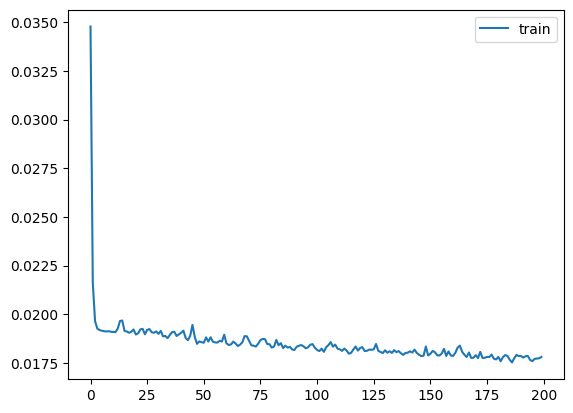

In [4]:
# make model
size_x = 484
size_y = 648
autoencoder = ColorCorrect((size_y, size_x, 3))
autoencoder.compile(optimizer='adam', loss=loss_after_sim2, run_eagerly=True)
# autoencoder.load_weights('../model_0.4/0.4')
autoencoder.build(input_shape=(None, size_y, size_x, 3))
autoencoder.summary()
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights= True)
callbacks = [ReportMetrics()]
# import datetime
# ! rm -rf ./logs/
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# dataset
train_path = '/Users/satyamgoyal/Downloads/EAAI 24 Research Paper/ColorblindCorrection/laboro_tomato/train'
train_set = np.array(make_dataset(train_path, 600, size_x=size_x, size_y=size_y))

val_path = '/Users/satyamgoyal/Downloads/EAAI 24 Research Paper/ColorblindCorrection/laboro_tomato/test'
val_set = np.array(make_dataset(val_path, 10, size_x=size_x, size_y=size_y))

# train
history = autoencoder.fit(train_set, train_set, epochs=200, shuffle=True, verbose=0, batch_size=32, callbacks=[callbacks, early], validation_data=(val_set, val_set))

# plot loss during training
history_dict = history.history
# plot learning curves
plt.plot(history_dict['loss'], label='train')
plt.legend()
plt.show()

In [5]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


1/1 [==============================] - 0s 204ms/step


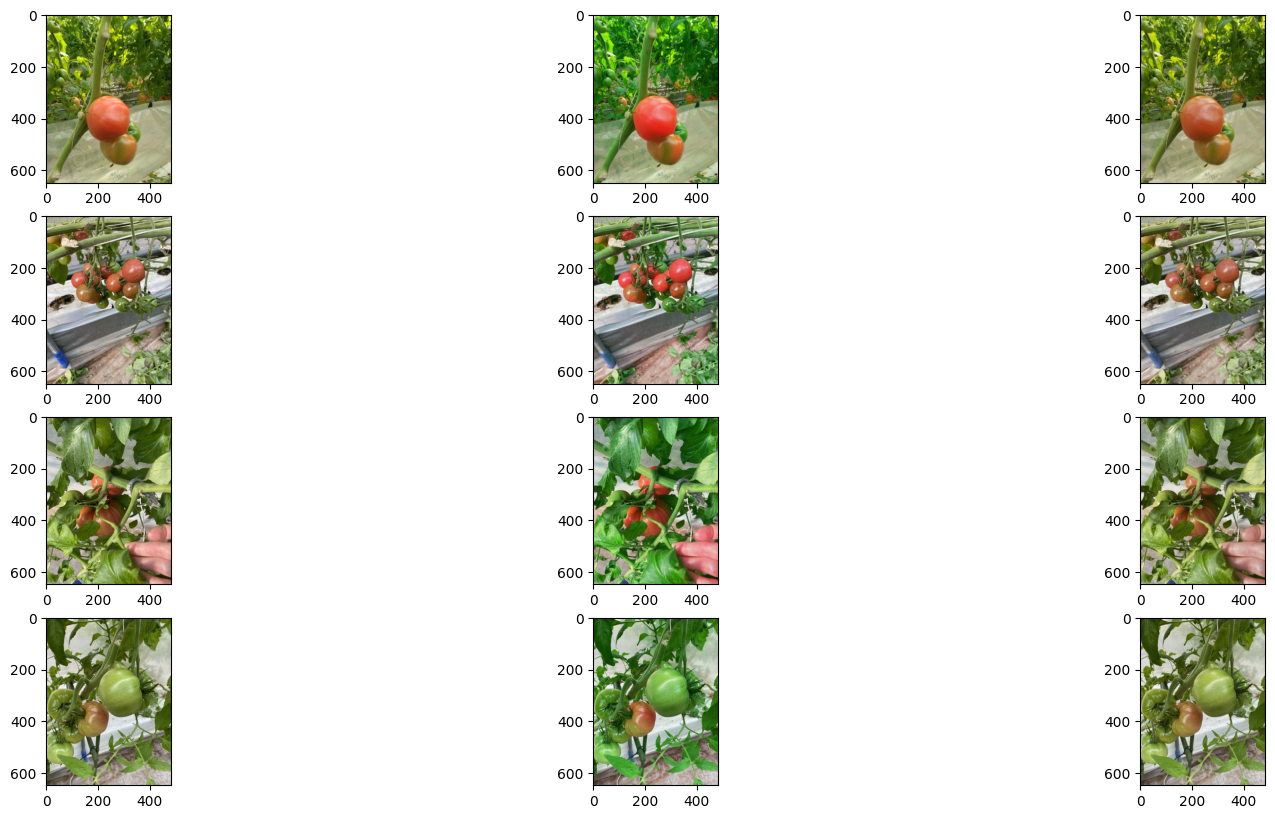

In [21]:
test_path = '/Users/satyamgoyal/Downloads/EAAI 24 Research Paper/ColorblindCorrection/laboro_tomato/test'
visualise_results(test_path, '0.3', 4, size_x, size_y, autoencoder=autoencoder)

In [5]:
autoencoder.save_weights('../model_0.4/0.4')

In [29]:
import tensorflow as tf
import numpy as np
import json
size_x = 484
size_y = 648
intensity = 0.5
saved = ColorCorrect((size_y, size_x, 3))
saved.compile(optimizer='adam', loss=loss_after_sim2, run_eagerly=True)
saved.load_weights('../model_{}/{}'.format(intensity, intensity))
test_path = '/Users/satyamgoyal/Downloads/EAAI 24 Research Paper/ColorblindCorrection/Satyam Code/test_images/arch_img.jpeg'
image_set = []
image = cv2.imread(test_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image = np.array(image)
image = image/255.0
image_set.append(image)
test_data = np.array(image_set)
new_data = []
new_data = np.array(test_data)
results = saved.predict(test_data)
with open('linear_simulation_data.json', 'r') as f:
    data = json.load(f)
# get the matrix
matrices = data.get('data')
matrix = []
for i in range(len(matrices)):
    if matrices[i].get('severity') == intensity:
        matrix = matrices[i].get('matrices')[1]
        break
matrix = np.array(matrix)
# fig, axs = plt.subplots(num_images, 3, figsize=(20, 10))
for i in range(2,3):
    original_img = image
    original_img = original_img * 255
    original_img = np.tensordot(original_img, matrix, axes=(-1, -1))
    original_img = np.ravel(original_img)
    original_img = Image.fromarray(original_img.reshape(size_y,size_x, 3).astype('uint8'))
    # original_img.save('cnn_results/qual_test/ishihara_test/original_simulated_{}.png'.format(i))
    # axs[i, 0].imshow(original_img)
    corrected_img = results[0]
    corrected_img = corrected_img * 255
    corrected_img[corrected_img < 0] = 0
    corrected_img[corrected_img > 255] = 255
    corrected_img = np.ravel(corrected_img)
    corrected_img = Image.fromarray(corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
    corrected_img.save('test_images/arch_img_corrected.png')
    # axs[i, 1].imshow(corrected_img)
    sim_corrected_img = results[0]
    sim_corrected_img = sim_corrected_img * 255
    sim_arr = matrix
    sim_corrected_img = np.tensordot(sim_corrected_img, sim_arr, axes=(-1, -1))
    sim_corrected_img[sim_corrected_img < 0] = 0
    sim_corrected_img[sim_corrected_img > 255] = 255
    sim_corrected_img = np.ravel(sim_corrected_img)
    sim_corrected_img = Image.fromarray(sim_corrected_img.reshape(size_y,size_x, 3).astype('uint8'))
    sim_corrected_img.save('test_images/arch_img_corrected_sim.png')

1/1 [==============================] - 0s 48ms/step


In [20]:
from average import run_average
import numpy as np

orig_image_directory = "../laboro_tomato/test_downsized"
average_mse = []
average_ssim = []

for i in np.arange(0.6, 0.7, 0.1):
    i = round(i, 1)
    corrected_image_directory = f"cnn_results/training_results_{i}"
    mse, ssim  = run_average(orig_image_directory, corrected_image_directory, 150)
    average_mse.append(mse)
    average_ssim.append(ssim)


Pair 0: Avg MSE: 309.97, Avg SSIM: 0.93
Pair 1: Avg MSE: 192.33, Avg SSIM: 0.94
Pair 2: Avg MSE: 213.41, Avg SSIM: 0.92
Pair 3: Avg MSE: 132.15, Avg SSIM: 0.93
Pair 4: Avg MSE: 204.84, Avg SSIM: 0.92
Pair 5: Avg MSE: 139.48, Avg SSIM: 0.94
Pair 6: Avg MSE: 171.55, Avg SSIM: 0.94
Pair 7: Avg MSE: 165.60, Avg SSIM: 0.94
Pair 8: Avg MSE: 294.24, Avg SSIM: 0.88
Pair 9: Avg MSE: 329.25, Avg SSIM: 0.95
Pair 10: Avg MSE: 199.08, Avg SSIM: 0.92
Pair 11: Avg MSE: 202.88, Avg SSIM: 0.92
Pair 12: Avg MSE: 477.86, Avg SSIM: 0.86
Pair 13: Avg MSE: 184.71, Avg SSIM: 0.92
Pair 14: Avg MSE: 358.56, Avg SSIM: 0.91
Pair 15: Avg MSE: 258.54, Avg SSIM: 0.90
Pair 16: Avg MSE: 240.79, Avg SSIM: 0.95
Pair 17: Avg MSE: 167.40, Avg SSIM: 0.92
Pair 18: Avg MSE: 120.22, Avg SSIM: 0.96
Pair 19: Avg MSE: 275.26, Avg SSIM: 0.90
Pair 20: Avg MSE: 160.58, Avg SSIM: 0.94
Pair 21: Avg MSE: 381.53, Avg SSIM: 0.93
Pair 22: Avg MSE: 472.66, Avg SSIM: 0.89
Pair 23: Avg MSE: 236.02, Avg SSIM: 0.91
Pair 24: Avg MSE: 327.79, 

In [22]:
average_mse

[214.69197816768934]

[137.6805335109068, 144.971768575446, 143.6648839640636, 193.269856210611, 178.60092990409825, 248.95526443949845, 432.4042795166864, 481.21802332898204, 640.7513805778032, 798.8894218668387]
[0.9342086097192575, 0.9285659556624566, 0.9324203771556757, 0.9176124350208725, 0.9230889782436188, 0.9160055944224047, 0.9159631947342924, 0.9153505405377974, 0.9259374764896542, 0.9212800666225013]


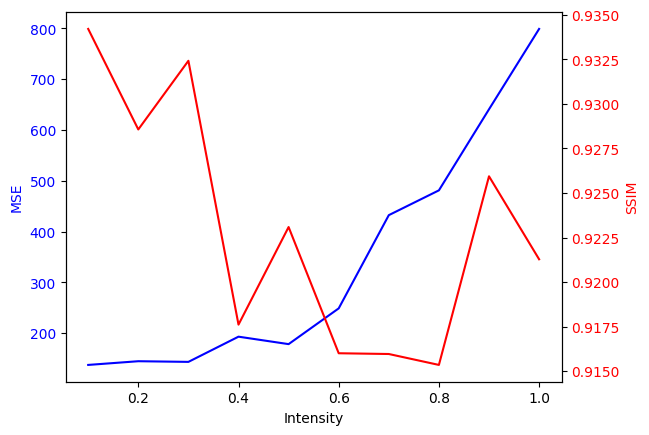

In [17]:
from matplotlib import pyplot as plt

# plot mse and ssim for each intensity starting from 0.3 to 1.0

print(average_mse)
print(average_ssim)

intensity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

fig, ax1 = plt.subplots()

ax1.set_ylabel('MSE', color='blue')
ax1.set_xlabel('Intensity')
ax1.plot(intensity, average_mse, 'blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('SSIM', color='red')  # we already handled the x-label with ax1
ax2.plot(intensity, average_ssim, 'red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

In [18]:
print(np.mean(average_mse))
print(np.mean(average_ssim))

340.04063418949346
0.9230433228608531
